In [141]:
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import repeat
from collections import defaultdict
import matplotlib.pyplot as plt



In [2]:
pd.set_option('display.max_columns', None)

In [3]:
work_path = '/cluster/raid/home/f80878961/agripol/'

In [4]:
pathogen_data_fn = '{}Agripol all pathogen data beta Actin complet to use for stats.xlsx'.format(work_path)

In [5]:
# to disable ssl certificate check...
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Parse pathogen data

In [6]:
dfs = pd.read_excel(pathogen_data_fn, sheet_name=None, engine='openpyxl')

/cluster/raid/home/f80878961/.conda/envs/planb/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():
/cluster/raid/home/f80878961/.conda/envs/planb/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():
/cluster/raid/home/f80878961/.conda/envs/planb/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():
/cluster/raid/home/f80878961/.conda/envs/planb/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():
/cluster/raid/home/f80878961/.conda/envs/planb/lib/python3.9/site-packages/openpyxl/

In [8]:
dfs.keys()

dict_keys(['Runs 2018', 'Runs 2019', 'Runs 2020', 'Runs 2021', 'Runs 2022', 'missing bactin'])

In [9]:
def clean_df(df, pathogens, apis_col, βActin_col):

    p2cols = defaultdict(list)
    columns = []
    curr_pathogen = None
    for c in df.columns:
        if c in pathogens:
            curr_pathogen = c
        if curr_pathogen and c not in {apis_col, βActin_col}:
            p2cols[curr_pathogen].append(c)
            columns.append(c)
    
    new_cols = []
    for p, cols in p2cols.items():
        assert len(cols) >1 & len(cols) <4
        
        # ct and detected?
        if len(cols) == 2:
            new_cols.extend(['{} Ct value'.format(p), '{} Detected'.format(p)])
        
        # ct, delta ct , and detected
        else:
            new_cols.extend(['{} Ct value'.format(p), '{} delta Ct'.format(p), '{} Detected'.format(p)])
    
    assert len(columns) == len(new_cols)

    return df, columns, new_cols

2018

get pathogen names from this first table

In [10]:
year = 2018
apis_col = "Apis mellifera (sert de contrôle interne à l'exploitabilité de l'ADN extrait)"
βActin_col = 'βActin RT'

In [11]:
df = dfs['Runs {}'.format(year)]
df.columns

Index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8',
       'Apis mellifera (sert de contrôle interne à l'exploitabilité de l'ADN extrait)',
       'Melissococcus plutonius', 'Unnamed: 11', 'Paenibacillus larvae',
       'Unnamed: 13', 'Ascosphera', 'Unnamed: 15', 'Nosema ceranae',
       'Unnamed: 17', 'Nosema apis', 'Unnamed: 19', 'βActin RT', 'DWV A',
       'Unnamed: 22', 'DWV B', 'Unnamed: 24', 'Unnamed: 25', 'DWV C',
       'Unnamed: 27', 'Unnamed: 28', 'SBV', 'Unnamed: 30', 'Unnamed: 31',
       'BCQV', 'Unnamed: 33', 'Unnamed: 34', 'ABPV', 'Unnamed: 36',
       'Unnamed: 37', 'KBV', 'Unnamed: 39', 'Unnamed: 40', 'IAPV',
       'Unnamed: 42', 'Unnamed: 43'],
      dtype='object')

In [12]:
pathogens = []
for c in df:
    if not c.startswith('Unnamed') and c not in {apis_col, βActin_col}:
        pathogens.append(c)

assert len(pathogens) == 13
pathogens

['Melissococcus plutonius',
 'Paenibacillus larvae',
 'Ascosphera',
 'Nosema ceranae',
 'Nosema apis',
 'DWV A',
 'DWV B',
 'DWV C',
 'SBV',
 'BCQV',
 'ABPV',
 'KBV',
 'IAPV']

In [13]:
df, columns, new_cols = clean_df(df, pathogens, apis_col, βActin_col)

other_columns = ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
other_columns_new_names = ['N° tube', 'Rucher', 'Colonie', 'Date', 'Visite']
for i, oc in enumerate(other_columns):
    assert dfs['Runs {}'.format(year)][oc][0] == other_columns_new_names[i]

In [14]:
# skip first row and rows without qPCR values
df_2018 = df.loc[1:788, other_columns + columns]
df_2018.columns = other_columns_new_names + new_cols

# filter rows without Rucher, Colonie, etc. even if there are PCR values ?

2019

In [15]:
year = 2019
apis_col = "Apis mellifera (sert de contrôle interne à l'exploitabilité de l'ADN extrait)"
βActin_col = 'β-Actin RT run no 200824 1+2 et 2008243'

df = dfs['Runs {}'.format(year)]
df, columns, new_cols = clean_df(df, pathogens, apis_col, βActin_col)

other_columns = ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
other_columns_new_names = ['N° tube', 'Rucher', 'Colonie', 'Date', 'Visite']
for i, oc in enumerate(other_columns):
    assert dfs['Runs {}'.format(year)][oc][0] == other_columns_new_names[i]

In [16]:
# skip first row and rows without qPCR values
df_2019 = df.loc[1:1076, other_columns + columns]
df_2019.columns = other_columns_new_names + new_cols

2020

- no IAPV

In [41]:
year = 2020
apis_col = "Apis mellifera"
βActin_col = 'β-Actin (internal control for RNA quality)'

In [42]:
df = dfs['Runs {}'.format(year)]

In [43]:
df = df.rename(columns={'Nosema \nceranae': 'Nosema ceranae', 'Nosema \napis':'Nosema apis'}).drop('Unnamed: 46', axis=1)

In [44]:
df, columns, new_cols = clean_df(df, pathogens, apis_col, βActin_col)

other_columns = ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
other_columns_new_names = ['N° tube', 'Rucher', 'Colonie', 'Date', 'Visite']
for i, oc in enumerate(other_columns):
    assert dfs['Runs {}'.format(year)][oc][0] == other_columns_new_names[i]

In [45]:
# skip first row and rows without qPCR values
df_2020 = df.loc[1:934, other_columns + columns]
df_2020.columns = other_columns_new_names + new_cols

2021

In [53]:
year = 2021
apis_col = "Apis mellifera"
βActin_col = 'β-Actin (internal control for RNA quality)'

In [54]:
df = dfs['Runs {}'.format(year)]

In [55]:
df = df.rename(columns={'Nosema \nceranae': 'Nosema ceranae', 'Nosema \napis':'Nosema apis'})

In [56]:
df, columns, new_cols = clean_df(df, pathogens, apis_col, βActin_col)

other_columns = ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
other_columns_new_names = ['N° tube', 'Rucher', 'Colonie', 'Date', 'Visite']
for i, oc in enumerate(other_columns):
    assert dfs['Runs {}'.format(year)][oc][0] == other_columns_new_names[i]

In [61]:
# skip first row and rows without qPCR values
df_2021 = df.loc[1:951, other_columns + columns]
df_2021.columns = other_columns_new_names + new_cols

2022

- no ABPV, KBV, IAPV, which are strains of KIABPV --> assumption KIABPV = IAPV as no ABPV and KBV in 2018-2021

In [107]:
year = 2022
apis_col = "Apis mellifera"
βActin_col = 'β-Actin (internal control for RNA quality)'

In [108]:
df = dfs['Runs {}'.format(year)]

In [109]:
df = df.rename(columns={'Nosema \nceranae': 'Nosema ceranae', 'Nosema Apis':'Nosema apis', 'KIABPV' : 'ABPV'}).drop('Ct values for ABPV, KBV IAPV not available this year', axis=1)

In [110]:
df, columns, new_cols = clean_df(df, pathogens, apis_col, βActin_col)

other_columns = ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
other_columns_new_names = ['N° tube', 'Rucher', 'Colonie', 'Date', 'Visite']
for i, oc in enumerate(other_columns):
    assert dfs['Runs {}'.format(year)][oc][0] == other_columns_new_names[i]

In [113]:
# skip first row and rows without qPCR values
df_2022 = df.loc[1:957, other_columns + columns]
df_2022.columns = other_columns_new_names + new_cols

Merge datasets

In [114]:
print(df_2018.shape)
print(df_2019.shape)
print(df_2020.shape)
print(df_2021.shape)
print(df_2022.shape)

(788, 38)
(1076, 39)
(934, 36)
(951, 39)
(957, 29)


In [116]:
print(set(df_2019.columns).difference(df_2018))
print(set(df_2019.columns).difference(df_2020))
print(set(df_2019.columns).difference(df_2021))
print(set(df_2019.columns).difference(df_2022))

{'DWV A delta Ct'}
{'IAPV delta Ct', 'IAPV Detected', 'IAPV Ct value'}
set()
{'SBV Ct value', 'IAPV Ct value', 'KBV Ct value', 'SBV delta Ct', 'KBV Detected', 'IAPV Detected', 'ABPV delta Ct', 'SBV Detected', 'IAPV delta Ct', 'KBV delta Ct'}


In [117]:
df_all = pd.concat([df_2018, df_2019, df_2020, df_2021, df_2022], ignore_index=True)

In [118]:
df_all.shape

(4706, 39)

In [119]:
pathogen_nr = [0] * len(df_all)

df_prev_rows = [list] * len(df_all)
# df_abun_rows = [] * len(df_2019)

for i in range(len(df_all)):
    row = [0] * len(pathogens)
    for j, p in enumerate(pathogens):
        if df_all.iloc[i, df_all.columns.get_loc('{} Detected'.format(p))] == '+':
            pathogen_nr[i] += 1
            row[j] = 1
    df_prev_rows[i] = row

In [120]:
df_prev = pd.DataFrame(df_prev_rows, columns=pathogens)

In [121]:
df_prev

,Melissococcus plutonius,Paenibacillus larvae,Ascosphera,Nosema ceranae,Nosema apis,DWV A,DWV B,DWV C,SBV,BCQV,ABPV,KBV,IAPV
0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701,0,0,0,1,0,0,0,0,0,0,0,0,0
4702,0,0,0,1,0,0,0,0,0,0,0,0,0
4703,0,0,0,1,0,0,0,0,0,0,0,0,0
4704,0,0,0,1,0,0,0,0,0,0,0,0,0


# Cluster samples by presence absence of pathogens

In [122]:
sum(df_prev['KBV'])
sum(df_prev['IAPV'])

0

/cluster/raid/home/f80878961/.conda/envs/planb/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


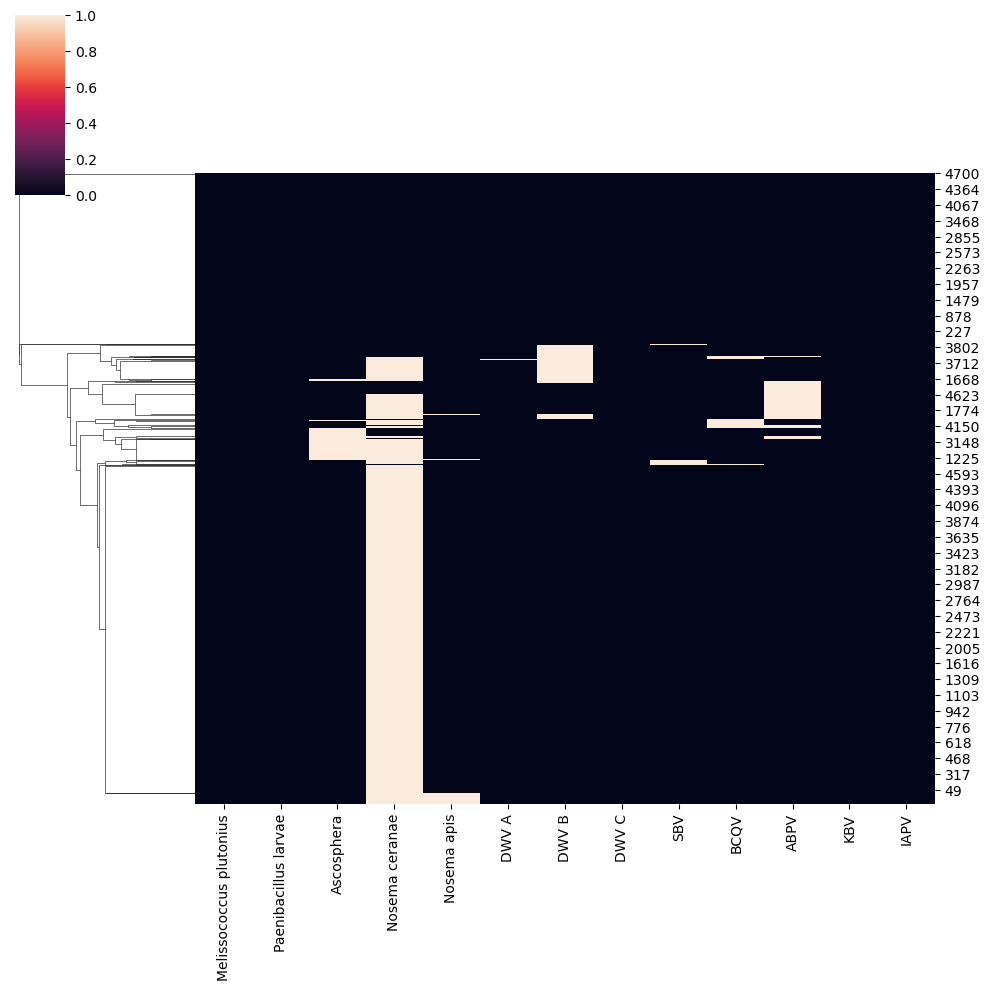

In [123]:
cg = sns.clustermap(df_prev, metric='jaccard', col_cluster=False)

In [125]:
df_prev.sum(axis=0)

Melissococcus plutonius       1
Paenibacillus larvae          4
Ascosphera                  265
Nosema ceranae             3155
Nosema apis                  87
DWV A                        15
DWV B                       325
DWV C                         0
SBV                          46
BCQV                        102
ABPV                        341
KBV                           0
IAPV                          0
dtype: int64

/tmp/ipykernel_1972489/1230642133.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


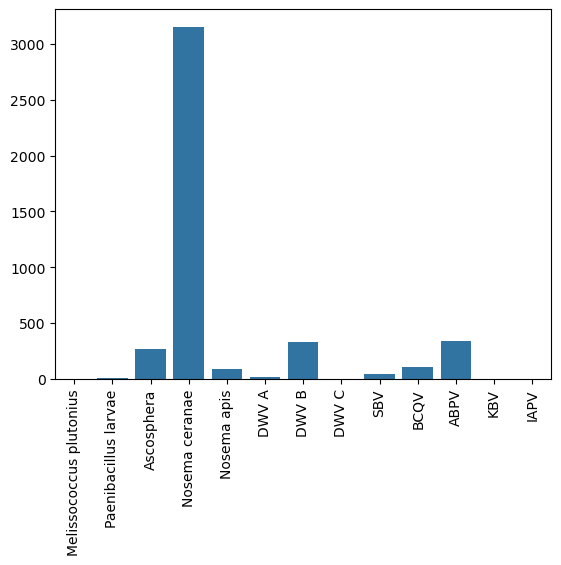

In [143]:
ax = sns.barplot(df_prev.sum(axis=0))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()


In [144]:
min_patho_nr = 3
df_prev_filtered = df_prev[df_prev.sum(axis=1) >= min_patho_nr].drop(columns=df_prev.columns[df_prev.sum(axis=0) == 0])

In [146]:
df_prev_filtered.shape

(131, 10)

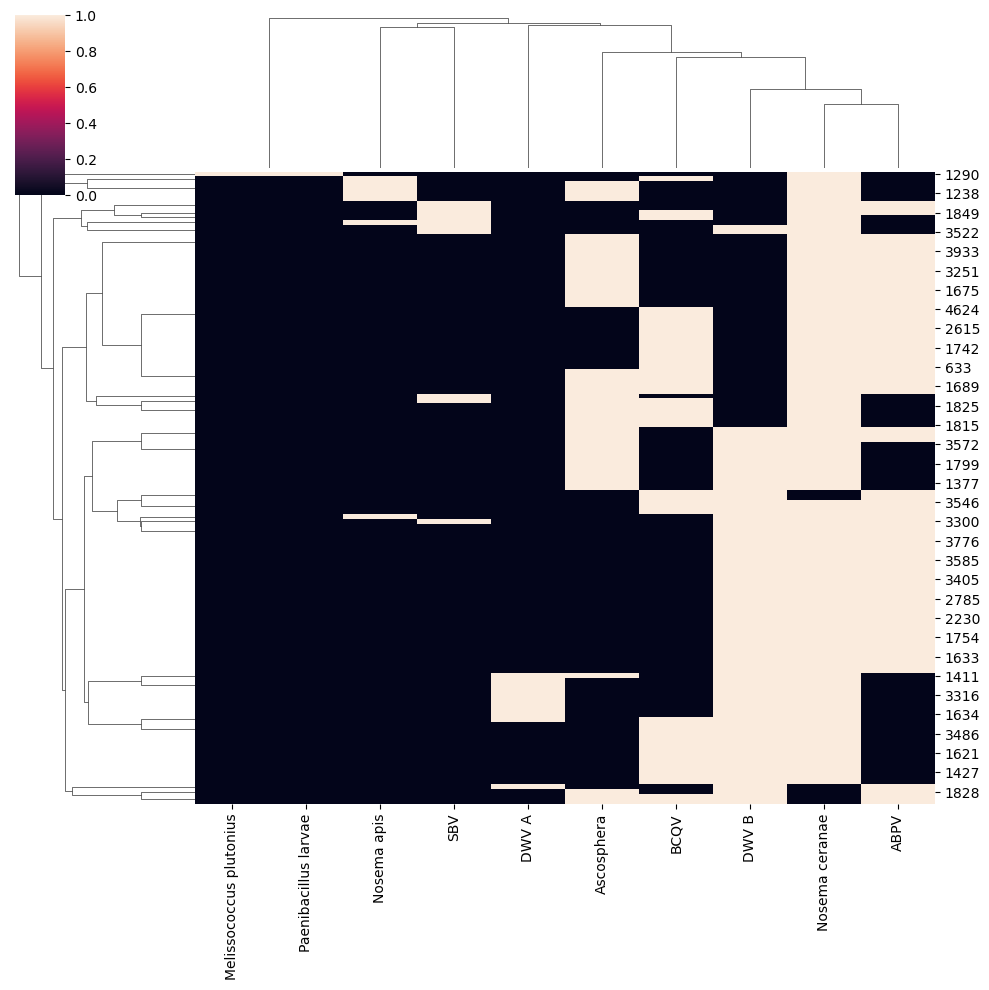

In [149]:
cg = sns.clustermap(df_prev_filtered, metric='jaccard', col_cluster=True)

In [229]:
clustered_rows = np.array(df_prev_filtered.index[cg.dendrogram_row.reordered_ind])

In [230]:
# new index clustered
new_idx_clustered = np.array(cg.dendrogram_row.reordered_ind)

# reorder table accordingly
df_prev_filtered_clust = df_prev_filtered.iloc[new_idx_clustered, :]

In [235]:
original_index = 1290 # bacteria
original_index = 1411

idx = np.argwhere(df_prev_filtered_clust.index == original_index).flatten()[0]
idx

104

In [236]:
rge = 5

In [237]:
left_p = (idx - rge) if idx > rge else 0
right_p = (idx + rge) if (idx + rge) < len(df_prev_filtered) else len(df_prev_filtered)
zoom_df = df_prev_filtered_clust.iloc[left_p : right_p, :]
zoom_df

,Melissococcus plutonius,Paenibacillus larvae,Ascosphera,Nosema ceranae,Nosema apis,DWV A,DWV B,SBV,BCQV,ABPV
1653,0,0,0,1,0,0,1,0,0,1
1633,0,0,0,1,0,0,1,0,0,1
221,0,0,0,1,0,0,1,0,0,1
128,0,0,0,1,0,0,1,0,0,1
187,0,0,0,1,0,0,1,0,0,1
1411,0,0,1,1,0,1,1,0,0,0
3631,0,0,0,1,0,1,1,0,0,0
3553,0,0,0,1,0,1,1,0,0,0
3371,0,0,0,1,0,1,1,0,0,0
3316,0,0,0,1,0,1,1,0,0,0


<Axes: >

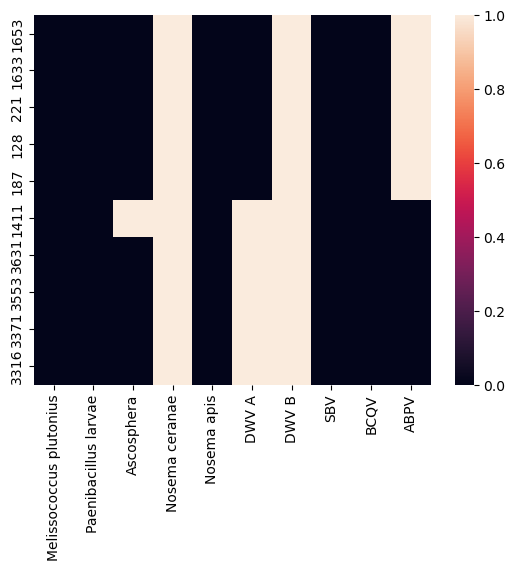

In [238]:
sns.heatmap(zoom_df)

In [239]:
df_all[original_index:original_index+1]

,N° tube,Rucher,Colonie,Date,Visite,Melissococcus plutonius Ct value,Melissococcus plutonius Detected,Paenibacillus larvae Ct value,Paenibacillus larvae Detected,Ascosphera Ct value,Ascosphera Detected,Nosema ceranae Ct value,Nosema ceranae Detected,Nosema apis Ct value,Nosema apis Detected,DWV A Ct value,DWV A Detected,DWV B Ct value,DWV B delta Ct,DWV B Detected,DWV C Ct value,DWV C delta Ct,DWV C Detected,SBV Ct value,SBV delta Ct,SBV Detected,BCQV Ct value,BCQV delta Ct,BCQV Detected,ABPV Ct value,ABPV delta Ct,ABPV Detected,KBV Ct value,KBV delta Ct,KBV Detected,IAPV Ct value,IAPV delta Ct,IAPV Detected,DWV A delta Ct
1411,624,R15,C04,2019-08-20 00:00:00,V3,flat,-,36.05,-,23.17,+,18.845,+,flat,-,30.41,+,33.56,-1.06,+,flat,NaN,-,flat,NaN,-,25.72,NaN,-,NaN,NaN,-,NaN,NaN,-,NaN,NaN,-,2.09


TO DO:
- other metadata


-  understand clusters
-  think abundances (how treat absences, mask value when absent)
-  validate I understood correctly these tables...
